# Deep Neural Network 



In [1]:
!pip install future
!pip install pandas
!pip install torchvision

In [18]:
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.data import get_MNIST_data, get_normalized_MNIST_data, get_california_housing_data, get_california_housing_normalized__data
from builtins import range
import numpy as np
import matplotlib.pyplot as plt
from utils.solver import *
import pandas as pd
from sklearn.datasets import fetch_california_housing
import numpy as np
import torch
import torch.nn as nn


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.cmap'] = 'gray'

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

# Affine layer: forward
Implement the `affine_forward` function.

In [2]:
def affine_forward(x, w, b):
    N = x.shape[0]
    x_reshaped = x.reshape(N, -1)
    out = np.dot(x_reshaped, w) + b
    cache = (x, w, b)
    return out, cache


You can test your implementaion by running the following:

In [3]:
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

print('The error should be around e-9 or less.')
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))


The error should be around e-9 or less.
Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
def affine_backward(dout, cache):
    x, w, b = cache
    N = x.shape[0]
    x_reshaped = x.reshape(N, -1)
    dx_reshaped = np.dot(dout, w.T)  
    dw = np.dot(x_reshaped.T, dout)  
    db = np.sum(dout, axis=0)        
    dx = dx_reshaped.reshape(x.shape)
    return dx, dw, db

You can test your implementation using numeric gradient checking:

In [7]:
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

print('The error should be around e-10 or less.')
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

The error should be around e-10 or less.
Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using numeric gradient checking.

In [8]:
def relu_forward(x):
    out = np.maximum(0, x)  
    cache = x               
    return out, cache

You can test your implementaion by running the following:

In [9]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

print('The error should be on the order of e-8.')
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

The error should be on the order of e-8.
Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function.

In [10]:
def relu_backward(dout, cache):
    x = cache
    dx = dout * (x > 0) 
    return dx

You can test your implementation using numeric gradient checking:

In [11]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

print('The error should be on the order of e-12')
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

The error should be on the order of e-12
Testing relu_backward function:
dx error:  3.2756349136310288e-12


# Sigmoid activation: forward
Implement the forward pass for the Sigmoid activation function in the `sigmoid_forward` function and test your implementation using numeric gradient checking.

In [27]:
def sigmoid_forward(x):
    out = 1 / (1 + np.exp(-x))
    cache = x
    return out, cache

You can test your implementaion by running the following:

In [29]:
x = np.linspace(-6, 6, num=12).reshape(3, 4)

out, _ = sigmoid_forward(x)
correct_out = np.array([[0.00247262, 0.00732514, 0.0214955 , 0.06138311],
                        [0.16296047, 0.36691963, 0.63308037, 0.83703953],
                        [0.93861689, 0.9785045 , 0.99267486, 0.99752738]])

print('The error should be on the order of e-7')
print('Testing sigmoid_forward function:')
print('difference: ', rel_error(out, correct_out))

The error should be on the order of e-7
Testing sigmoid_forward function:
difference:  6.383174040859927e-07


# Sigmoid activation: backward
Now implement the backward pass for the Sigmoid activation function in the `sigmoid_backward` function.

In [30]:
def sigmoid_backward(dout, cache):
    x = cache
    sig = 1 / (1 + np.exp(-x))
    dx = dout * ((sig) * (1 - sig)) 
    return dx

You can test your implementation using numeric gradient checking:

In [31]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: sigmoid_forward(x)[0], x, dout)

_, cache = sigmoid_forward(x)
dx = sigmoid_backward(dout, cache)

print('The error should be on the order of e-11')
print('Testing sigmoid_backward function:')
print('dx error: ', rel_error(dx_num, dx))

The error should be on the order of e-11
Testing sigmoid_backward function:
dx error:  3.446520386706568e-11


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. Implement the forward and backward pass for the affine layer followed by a ReLU nonlinearity in the `affine_relu_forward` and `affine_relu_backward` functions. 

In [146]:
def affine_relu_forward(x, w, b):
    N = x.shape[0]
    x_reshaped = x.reshape(N, -1)
    z = np.dot(x_reshaped, w) + b 
    out = np.maximum(0, z) 
    cache = (x, w, b, z)
    return out, cache

In [147]:
def affine_relu_backward(dout, cache):
    x, w, b, z = cache  
    dz = dout * (z > 0) 
    N = x.shape[0]  
    x_reshaped = x.reshape(N, -1) 
    dw = np.dot(x_reshaped.T, dz) 
    db = np.sum(dz, axis=0)  
    dx_reshaped = np.dot(dz, w.T)  
    dx = dx_reshaped.reshape(x.shape)  
    return dx, dw, db


You can test your implementation using numeric gradient checking:

In [188]:
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Relative error should be around e-10 or less.')
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Relative error should be around e-10 or less.
Testing affine_relu_forward and affine_relu_backward:
dx error:  2.2995909845854045e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss Function: Softmax
Now implement the loss and gradient for softmax in the `softmax_loss` function.

In [20]:
def softmax_loss(x, y):
    N = x.shape[0] 
    C = x.shape[1]  
    x -= np.max(x, axis=1, keepdims=True)
    exp_scores = np.exp(x)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  
    correct_logprobs = -np.log(probs[np.arange(N), y]) 
    loss = np.sum(correct_logprobs) / N  
    dx = probs.copy()  
    dx[np.arange(N), y] -= 1  
    dx /= N  
    return loss, dx


def cross_entropy_loss_torch(x, y):
    criterion = nn.CrossEntropyLoss()  
    inputs = torch.tensor(x, dtype=torch.float32, requires_grad=True)  
    labels = torch.tensor(y, dtype=torch.long)
    loss = criterion(inputs, labels)
    loss.backward() 
    return loss.item(), inputs.grad.numpy()  



You can make sure that the implementations are correct by running the following:

In [21]:
x = np.array([[1.0, 2.0, 3.0],   
              [1.0, 2.0, 3.0],  
              [1.0, 2.0, 3.0]])
y = np.array([2, 0, 1])  

loss_softmax, dx_softmax = softmax_loss(x, y)
loss_cross_entropy, dx_cross_entropy = cross_entropy_loss_torch(x, y)

print(f"Softmax Loss: {loss_softmax}")
print(f"Cross-Entropy Loss (PyTorch): {loss_cross_entropy}")
print(f"Gradient from softmax loss:\n{dx_softmax}")
print(f"Gradient from Cross-Entropy loss (PyTorch):\n{dx_cross_entropy}")
print('dx error: ', rel_error(dx_softmax, dx_cross_entropy))

Softmax Loss: 1.4076059644443804
Cross-Entropy Loss (PyTorch): 1.4076060056686401
Gradient from softmax loss:
[[ 0.03001019  0.08157616 -0.11158635]
 [-0.30332314  0.08157616  0.22174699]
 [ 0.03001019 -0.25175718  0.22174699]]
Gradient from Cross-Entropy loss (PyTorch):
[[ 0.03001019  0.08157617 -0.11158633]
 [-0.30332315  0.08157617  0.22174701]
 [ 0.03001019 -0.25175717  0.22174701]]
dx error:  7.060196027361182e-08


# Loss Function: MSE
Now implement the loss and gradient for mean squared error in the `mse_loss` function.

In [69]:
def mse_loss(x, y):
    N = x.shape[0]  
    loss = np.sum((x - y) ** 2) / N  
    dx = 2 * (x - y) / N  
    return loss, dx

You can make sure that the implementations are correct by running the following:

In [70]:
np.random.seed(231)
num_inputs = 50
x = np.random.randn(num_inputs)
y = np.random.randn(num_inputs)

dx_num = eval_numerical_gradient(lambda x: mse_loss(x, y)[0], x, verbose=False)
loss, dx = mse_loss(x, y)

print('Loss should be close to 1.9 and dx error should be around e-9')
print('Testing mse_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Loss should be close to 1.9 and dx error should be around e-9
Testing mse_loss:
loss:  1.8672282748726519
dx error:  2.8607953262121067e-09


# Multi-Layer Fully Connected Network
In this part, you will implement a fully connected network with an arbitrary number of hidden layers.

In [249]:
class FullyConnectedNet(object):
    def __init__(
        self,
        category,
        hidden_dims,
        input_dim=784,
        output_dim=10,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
    ):
        self.category = category
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        prev_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            self.params[f'W{i+1}'] = np.random.randn(prev_dim, hidden_dim) * weight_scale
            self.params[f'b{i+1}'] = np.zeros(hidden_dim)
            prev_dim = hidden_dim
        self.params[f'W{self.num_layers}'] = np.random.randn(prev_dim, output_dim) * weight_scale
        self.params[f'b{self.num_layers}'] = np.zeros(output_dim)

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        cache = {}
        out = X
        for i in range(1, self.num_layers):
            out, cache[i] = affine_relu_forward(out, self.params[f'W{i}'], self.params[f'b{i}'])
        scores, cache[self.num_layers] = affine_forward(out, self.params[f'W{self.num_layers}'], self.params[f'b{self.num_layers}'])

        if mode == "test":
            return scores

        loss, dout = 0.0, None
        if self.category == "classification":
            loss, dout = softmax_loss(scores, y)
        elif self.category == "regression":
            loss, dout = mse_loss(scores, y)

        for i in range(1, self.num_layers + 1):
            loss += 0.5 * self.reg * np.sum(self.params[f'W{i}']**2)

        grads = {}
        dout, grads[f'W{self.num_layers}'], grads[f'b{self.num_layers}'] = affine_backward(dout, cache[self.num_layers])

        for i in range(self.num_layers - 1, 0, -1):
            dout, grads[f'W{i}'], grads[f'b{i}'] = affine_relu_backward(dout, cache[i])
            grads[f'W{i}'] += self.reg * self.params[f'W{i}']  

        return loss, grads


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [241]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        "classification",
        [H1, H2],
        input_dim=D,
        output_dim=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.025267445229243e-07
W2 relative error: 2.2120479296856732e-05
W3 relative error: 4.5623278736665505e-07
b1 relative error: 4.660094188020383e-09
b2 relative error: 2.085654200257447e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.904542008453064e-09
W2 relative error: 6.86942277940646e-08
W3 relative error: 1.0
b1 relative error: 1.4752427901105963e-08
b2 relative error: 1.4615869332918208e-09
b3 relative error: 1.3200479211447775e-10


## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.

Implement the SGD+momentum update rule in the function `sgd_momentum`.

In [74]:
def sgd_momentum(w, dw, config=None):
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("momentum", 0.9)
    v = config.get("velocity", np.zeros_like(w))

    v = config["momentum"] * v - config["learning_rate"] * dw  
    next_w = w + v  
    config["velocity"] = v  
    return next_w, config


Run the following to check your implementation. You should see errors less than e-8.

In [75]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


# MNIST
MNIST is a widely used dataset of handwritten digits that contains 60,000 handwritten digits for training a machine learning model and 10,000 handwritten digits for testing the model.

In [285]:
X_train, y_train, X_val, y_val, X_test, y_test = get_MNIST_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


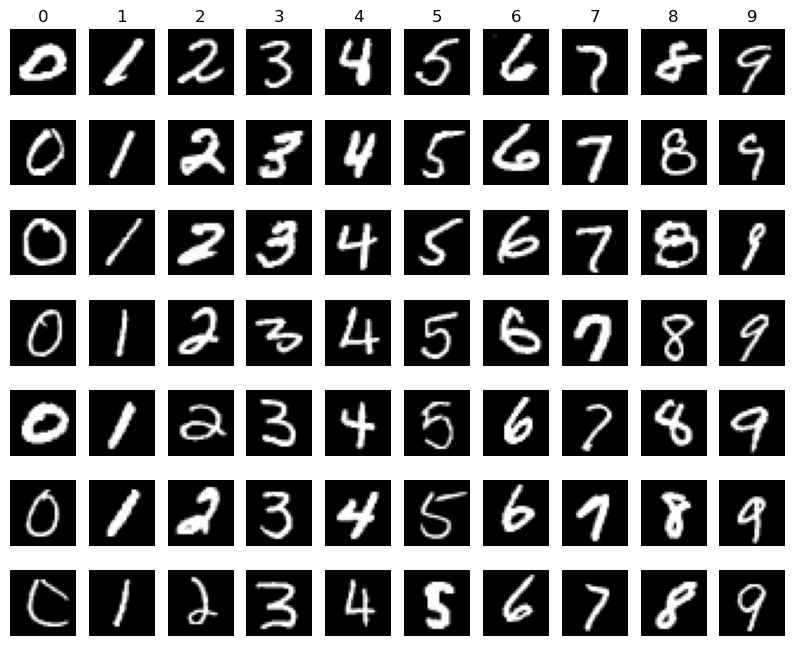

In [286]:
classes = list(range(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((28, 28)))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Data normalization is an important step which ensures that each input parameter has a similar data distribution. This makes convergence faster while training the network.

In [287]:
X_train, X_val, X_test = get_normalized_MNIST_data(X_train, X_val, X_test)

# Train a Good Model!
Open the file `solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train the best fully connected model that you can on MNIST, storing your best model in the `MNIST_best_model` variable. We require you to get at least 95% accuracy on the validation set using a fully connected network.

In [80]:
data = {
    'X_train': X_train,
    'y_train': y_train.astype(int),
    'X_val': X_val,
    'y_val': y_val.astype(int),
    'X_test': X_test,
    'y_test': y_test.astype(int)
}

model = FullyConnectedNet(
    category='classification',  
    hidden_dims=[100, 100],  
    input_dim=784,           
    output_dim=10,          
    dtype=np.float64 
)

solver = Solver(model, data,
                update_rule=sgd_momentum,
                optim_config={
                  'learning_rate': 1e-3,  
                },
                lr_decay=0.95,  
                num_epochs=100,  
                batch_size=200, 
                print_every=100)  

solver.train()

MNIST_solver = solver
MNIST_best_model = model


(Iteration 1 / 25000) loss: 2.302542
(Epoch 0 / 100) train acc: 0.110000; val_acc: 0.113400
(Iteration 101 / 25000) loss: 2.302166
(Iteration 201 / 25000) loss: 2.301465
(Epoch 1 / 100) train acc: 0.122000; val_acc: 0.106400
(Iteration 301 / 25000) loss: 2.301579
(Iteration 401 / 25000) loss: 2.303391
(Epoch 2 / 100) train acc: 0.121000; val_acc: 0.106300
(Iteration 501 / 25000) loss: 2.301679
(Iteration 601 / 25000) loss: 2.298368
(Iteration 701 / 25000) loss: 2.300754
(Epoch 3 / 100) train acc: 0.104000; val_acc: 0.106600
(Iteration 801 / 25000) loss: 2.299903
(Iteration 901 / 25000) loss: 2.295611
(Epoch 4 / 100) train acc: 0.131000; val_acc: 0.108100
(Iteration 1001 / 25000) loss: 2.292108
(Iteration 1101 / 25000) loss: 2.292912
(Iteration 1201 / 25000) loss: 2.283359
(Epoch 5 / 100) train acc: 0.229000; val_acc: 0.209700
(Iteration 1301 / 25000) loss: 2.278977
(Iteration 1401 / 25000) loss: 2.273188
(Epoch 6 / 100) train acc: 0.346000; val_acc: 0.326500
(Iteration 1501 / 25000) lo

(Iteration 13101 / 25000) loss: 0.255573
(Iteration 13201 / 25000) loss: 0.411299
(Epoch 53 / 100) train acc: 0.908000; val_acc: 0.921400
(Iteration 13301 / 25000) loss: 0.404178
(Iteration 13401 / 25000) loss: 0.223936
(Epoch 54 / 100) train acc: 0.919000; val_acc: 0.921200
(Iteration 13501 / 25000) loss: 0.252563
(Iteration 13601 / 25000) loss: 0.277584
(Iteration 13701 / 25000) loss: 0.265233
(Epoch 55 / 100) train acc: 0.924000; val_acc: 0.921400
(Iteration 13801 / 25000) loss: 0.356175
(Iteration 13901 / 25000) loss: 0.292569
(Epoch 56 / 100) train acc: 0.919000; val_acc: 0.921900
(Iteration 14001 / 25000) loss: 0.261287
(Iteration 14101 / 25000) loss: 0.242291
(Iteration 14201 / 25000) loss: 0.210978
(Epoch 57 / 100) train acc: 0.927000; val_acc: 0.922100
(Iteration 14301 / 25000) loss: 0.291844
(Iteration 14401 / 25000) loss: 0.257336
(Epoch 58 / 100) train acc: 0.933000; val_acc: 0.922600
(Iteration 14501 / 25000) loss: 0.351376
(Iteration 14601 / 25000) loss: 0.217582
(Iterati

In [102]:
data = {
    'X_train': X_train,
    'y_train': y_train.astype(int),
    'X_val': X_val,
    'y_val': y_val.astype(int),
    'X_test': X_test,
    'y_test': y_test.astype(int)
}

model = FullyConnectedNet(
    category='classification', 
    hidden_dims=[512,512],
    input_dim=784,              
    output_dim=10,            
    weight_scale=1e-2,
    dtype=np.float64             
)

solver = Solver(model, data,
                update_rule=sgd_momentum,
                optim_config={
                  'learning_rate': 1e-3,  
                },
                lr_decay=0.95,  
                num_epochs=100, 
                batch_size=200,  
                print_every=100)  

solver.train()

MNIST_solver = solver
MNIST_best_model = model

(Iteration 1 / 25000) loss: 2.302463
(Epoch 0 / 100) train acc: 0.171000; val_acc: 0.143700
(Iteration 101 / 25000) loss: 2.295216
(Iteration 201 / 25000) loss: 2.283641
(Epoch 1 / 100) train acc: 0.433000; val_acc: 0.453500
(Iteration 301 / 25000) loss: 2.270382
(Iteration 401 / 25000) loss: 2.244492
(Epoch 2 / 100) train acc: 0.487000; val_acc: 0.487100
(Iteration 501 / 25000) loss: 2.181447
(Iteration 601 / 25000) loss: 2.115158
(Iteration 701 / 25000) loss: 1.959764
(Epoch 3 / 100) train acc: 0.482000; val_acc: 0.496300
(Iteration 801 / 25000) loss: 1.852866
(Iteration 901 / 25000) loss: 1.470150
(Epoch 4 / 100) train acc: 0.571000; val_acc: 0.563600
(Iteration 1001 / 25000) loss: 1.334679
(Iteration 1101 / 25000) loss: 1.018171
(Iteration 1201 / 25000) loss: 0.890560
(Epoch 5 / 100) train acc: 0.738000; val_acc: 0.757900
(Iteration 1301 / 25000) loss: 0.842797
(Iteration 1401 / 25000) loss: 0.774525
(Epoch 6 / 100) train acc: 0.829000; val_acc: 0.845100
(Iteration 1501 / 25000) lo

(Iteration 13101 / 25000) loss: 0.224242
(Iteration 13201 / 25000) loss: 0.257268
(Epoch 53 / 100) train acc: 0.947000; val_acc: 0.946800
(Iteration 13301 / 25000) loss: 0.146132
(Iteration 13401 / 25000) loss: 0.195712
(Epoch 54 / 100) train acc: 0.955000; val_acc: 0.946900
(Iteration 13501 / 25000) loss: 0.200924
(Iteration 13601 / 25000) loss: 0.215585
(Iteration 13701 / 25000) loss: 0.167908
(Epoch 55 / 100) train acc: 0.945000; val_acc: 0.947000
(Iteration 13801 / 25000) loss: 0.169766
(Iteration 13901 / 25000) loss: 0.202945
(Epoch 56 / 100) train acc: 0.952000; val_acc: 0.947000
(Iteration 14001 / 25000) loss: 0.156683
(Iteration 14101 / 25000) loss: 0.102752
(Iteration 14201 / 25000) loss: 0.173640
(Epoch 57 / 100) train acc: 0.948000; val_acc: 0.947000
(Iteration 14301 / 25000) loss: 0.186885
(Iteration 14401 / 25000) loss: 0.223319
(Epoch 58 / 100) train acc: 0.956000; val_acc: 0.947200
(Iteration 14501 / 25000) loss: 0.206959
(Iteration 14601 / 25000) loss: 0.196807
(Iterati

In [119]:
data = {
    'X_train': X_train,
    'y_train': y_train.astype(int),
    'X_val': X_val,
    'y_val': y_val.astype(int),
    'X_test': X_test,
    'y_test': y_test.astype(int)
}

model = FullyConnectedNet(
    category='classification', 
    hidden_dims=[1024,1024],  
    input_dim=784,             
    output_dim=10,              
    weight_scale=1e-2,           
    dtype=np.float64             
)

solver = Solver(model, data,
                update_rule=sgd_momentum,
                optim_config={
                  'learning_rate': 1e-3,  
                },
                lr_decay=0.95,  
                num_epochs=100,  
                batch_size=200,  
                print_every=100)  

solver.train()

MNIST_solver = solver
MNIST_best_model = model

(Iteration 1 / 25000) loss: 2.302173
(Epoch 0 / 100) train acc: 0.093000; val_acc: 0.097100
(Iteration 101 / 25000) loss: 2.277987
(Iteration 201 / 25000) loss: 2.234863
(Epoch 1 / 100) train acc: 0.529000; val_acc: 0.545700
(Iteration 301 / 25000) loss: 2.172672
(Iteration 401 / 25000) loss: 2.007234
(Epoch 2 / 100) train acc: 0.536000; val_acc: 0.543000
(Iteration 501 / 25000) loss: 1.792225
(Iteration 601 / 25000) loss: 1.443852
(Iteration 701 / 25000) loss: 1.115415
(Epoch 3 / 100) train acc: 0.729000; val_acc: 0.737200
(Iteration 801 / 25000) loss: 0.989685
(Iteration 901 / 25000) loss: 0.814995
(Epoch 4 / 100) train acc: 0.844000; val_acc: 0.852600
(Iteration 1001 / 25000) loss: 0.647905
(Iteration 1101 / 25000) loss: 0.550582
(Iteration 1201 / 25000) loss: 0.529895
(Epoch 5 / 100) train acc: 0.871000; val_acc: 0.885500
(Iteration 1301 / 25000) loss: 0.554017
(Iteration 1401 / 25000) loss: 0.449695
(Epoch 6 / 100) train acc: 0.884000; val_acc: 0.898600
(Iteration 1501 / 25000) lo

(Iteration 13101 / 25000) loss: 0.101779
(Iteration 13201 / 25000) loss: 0.169119
(Epoch 53 / 100) train acc: 0.959000; val_acc: 0.952500
(Iteration 13301 / 25000) loss: 0.168189
(Iteration 13401 / 25000) loss: 0.132593
(Epoch 54 / 100) train acc: 0.947000; val_acc: 0.952500
(Iteration 13501 / 25000) loss: 0.286356
(Iteration 13601 / 25000) loss: 0.174094
(Iteration 13701 / 25000) loss: 0.135010
(Epoch 55 / 100) train acc: 0.944000; val_acc: 0.952500
(Iteration 13801 / 25000) loss: 0.226916
(Iteration 13901 / 25000) loss: 0.092811
(Epoch 56 / 100) train acc: 0.943000; val_acc: 0.952600
(Iteration 14001 / 25000) loss: 0.127226
(Iteration 14101 / 25000) loss: 0.214970
(Iteration 14201 / 25000) loss: 0.161452
(Epoch 57 / 100) train acc: 0.951000; val_acc: 0.952800
(Iteration 14301 / 25000) loss: 0.216836
(Iteration 14401 / 25000) loss: 0.091830
(Epoch 58 / 100) train acc: 0.960000; val_acc: 0.952600
(Iteration 14501 / 25000) loss: 0.111946
(Iteration 14601 / 25000) loss: 0.188486
(Iterati

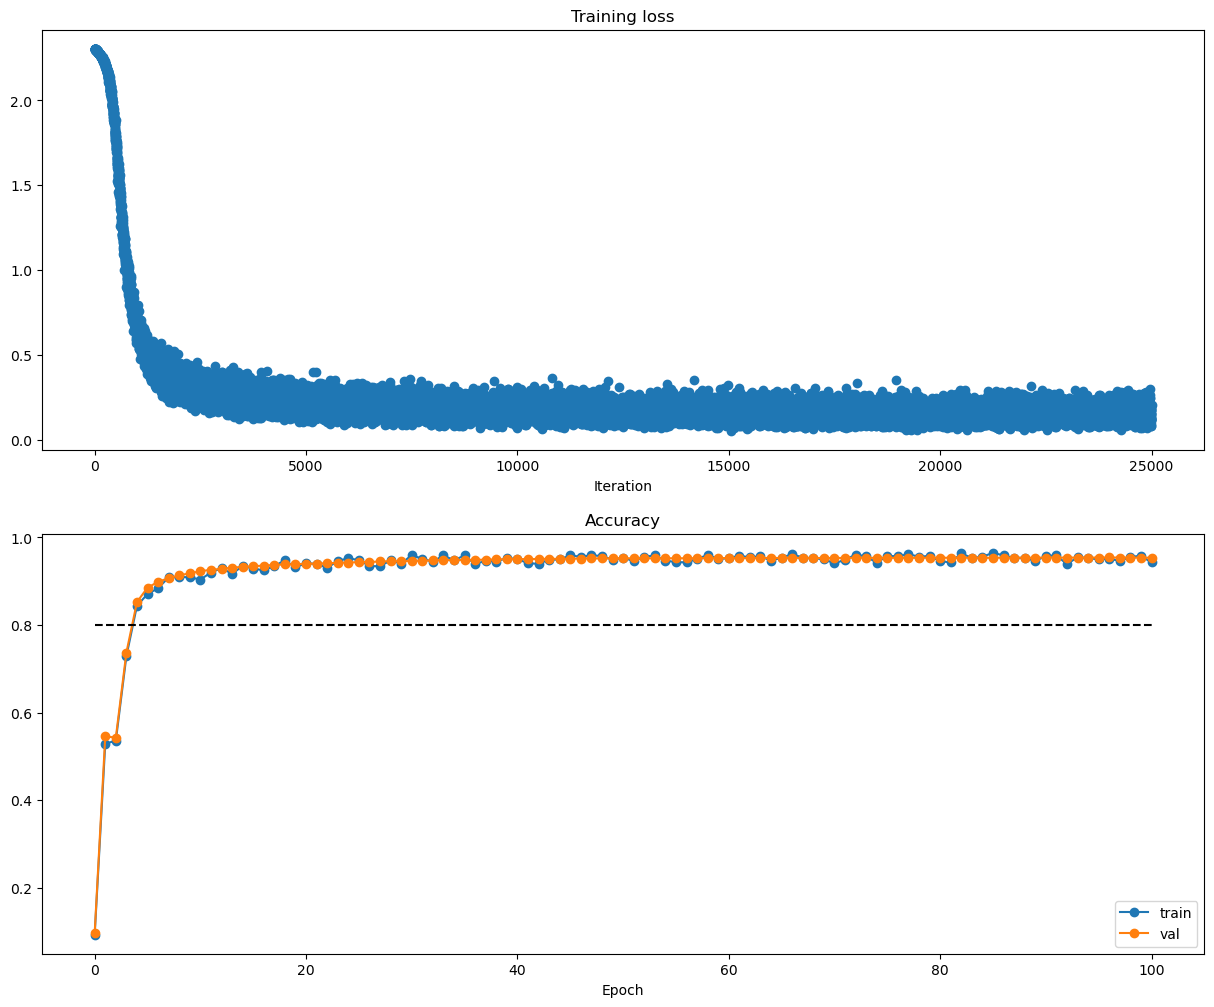

In [121]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(MNIST_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(MNIST_solver.train_acc_history, '-o', label='train')
plt.plot(MNIST_solver.val_acc_history, '-o', label='val')
plt.plot([0.8] * len(MNIST_solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 95% accuracy on the validation set.

In [144]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_val = X_val.reshape(X_val.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [156]:
y_test_pred = np.argmax(MNIST_best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(MNIST_best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.9543
Test set accuracy:  0.9487


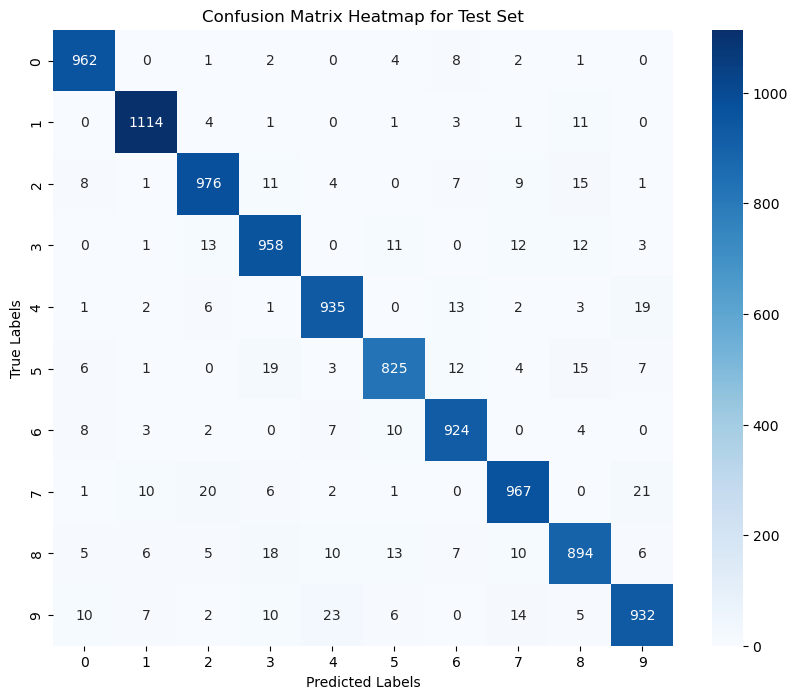

In [157]:
y_test_pred = np.argmax(MNIST_best_model.loss(data['X_test']), axis=1)
conf_matrix = confusion_matrix(data['y_test'], y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix Heatmap for Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Train another Good Model!


In [127]:
data = {
    'X_train': X_train,
    'y_train': y_train.astype(int),
    'X_val': X_val,
    'y_val': y_val.astype(int),
    'X_test': X_test,
    'y_test': y_test.astype(int)
}

model = FullyConnectedNet(
    category='classification',  
    hidden_dims=[512, 512],  
    input_dim=784,           
    output_dim=10,
    reg=1e-3,
    dtype=np.float64  
)

solver = Solver(model, data,
                update_rule=sgd_momentum,
                optim_config={
                  'learning_rate': 1e-2, 
                },
                lr_decay=0.95,  
                num_epochs=100, 
                batch_size=200,  
                print_every=100) 

solver.train()

MNIST_solver1 = solver
MNIST_best_model1 = model

(Iteration 1 / 25000) loss: 2.336317
(Epoch 0 / 100) train acc: 0.142000; val_acc: 0.111600
(Iteration 101 / 25000) loss: 1.782914
(Iteration 201 / 25000) loss: 0.471207
(Epoch 1 / 100) train acc: 0.890000; val_acc: 0.908700
(Iteration 301 / 25000) loss: 0.291694
(Iteration 401 / 25000) loss: 0.275018
(Epoch 2 / 100) train acc: 0.942000; val_acc: 0.945800
(Iteration 501 / 25000) loss: 0.174056
(Iteration 601 / 25000) loss: 0.269427
(Iteration 701 / 25000) loss: 0.213609
(Epoch 3 / 100) train acc: 0.964000; val_acc: 0.955300
(Iteration 801 / 25000) loss: 0.181523
(Iteration 901 / 25000) loss: 0.231415
(Epoch 4 / 100) train acc: 0.975000; val_acc: 0.962300
(Iteration 1001 / 25000) loss: 0.182204
(Iteration 1101 / 25000) loss: 0.116601
(Iteration 1201 / 25000) loss: 0.162211
(Epoch 5 / 100) train acc: 0.966000; val_acc: 0.964900
(Iteration 1301 / 25000) loss: 0.205236
(Iteration 1401 / 25000) loss: 0.152244
(Epoch 6 / 100) train acc: 0.980000; val_acc: 0.966800
(Iteration 1501 / 25000) lo

(Iteration 13101 / 25000) loss: 0.075013
(Iteration 13201 / 25000) loss: 0.071504
(Epoch 53 / 100) train acc: 0.997000; val_acc: 0.976500
(Iteration 13301 / 25000) loss: 0.090924
(Iteration 13401 / 25000) loss: 0.086500
(Epoch 54 / 100) train acc: 0.999000; val_acc: 0.976800
(Iteration 13501 / 25000) loss: 0.079254
(Iteration 13601 / 25000) loss: 0.080365
(Iteration 13701 / 25000) loss: 0.075003
(Epoch 55 / 100) train acc: 1.000000; val_acc: 0.976500
(Iteration 13801 / 25000) loss: 0.080920
(Iteration 13901 / 25000) loss: 0.078460
(Epoch 56 / 100) train acc: 0.999000; val_acc: 0.976900
(Iteration 14001 / 25000) loss: 0.078525
(Iteration 14101 / 25000) loss: 0.074236
(Iteration 14201 / 25000) loss: 0.074974
(Epoch 57 / 100) train acc: 0.996000; val_acc: 0.976600
(Iteration 14301 / 25000) loss: 0.080033
(Iteration 14401 / 25000) loss: 0.085308
(Epoch 58 / 100) train acc: 1.000000; val_acc: 0.976800
(Iteration 14501 / 25000) loss: 0.090166
(Iteration 14601 / 25000) loss: 0.077029
(Iterati

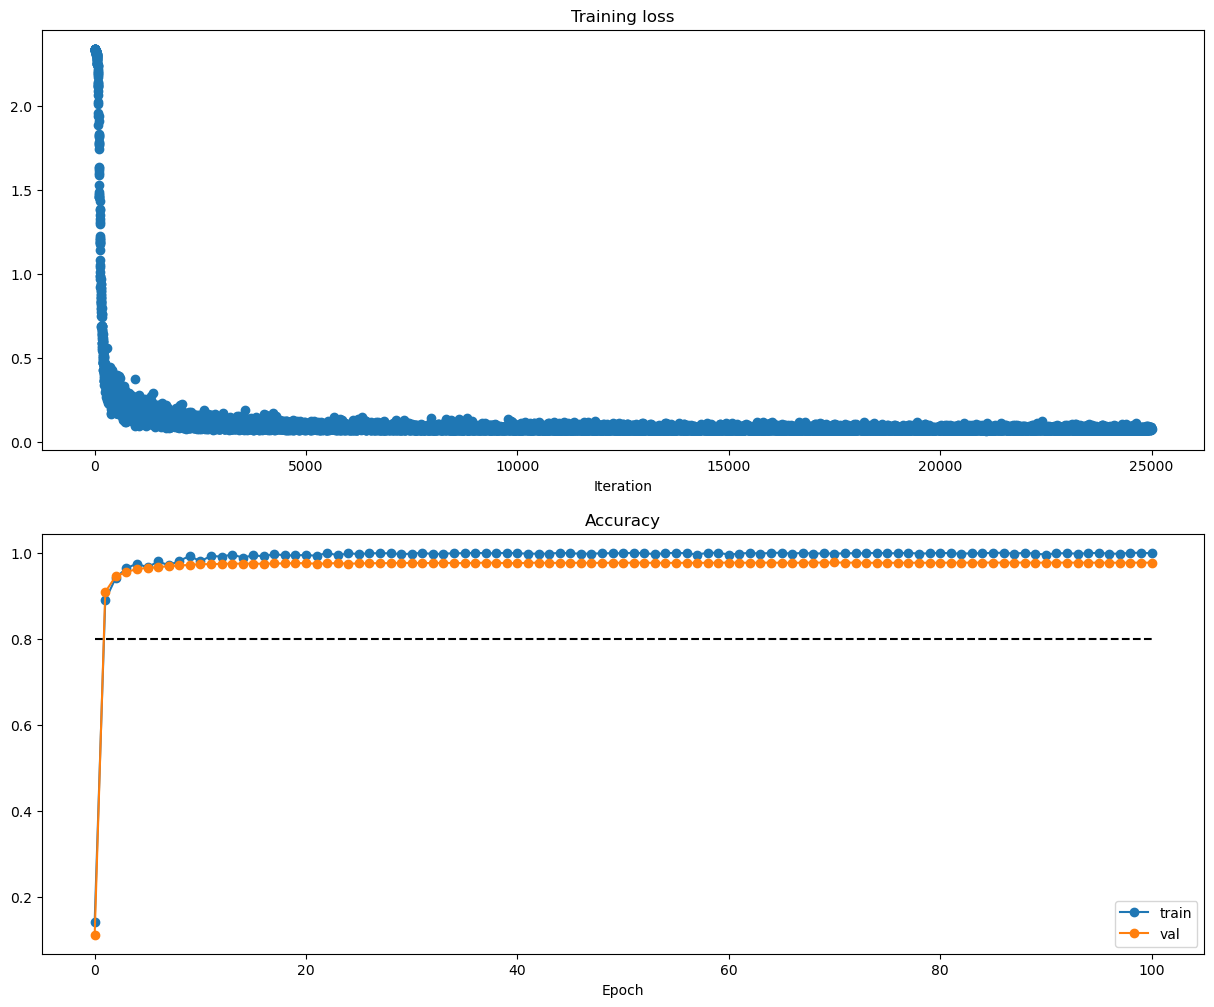

In [128]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(MNIST_solver1.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(MNIST_solver1.train_acc_history, '-o', label='train')
plt.plot(MNIST_solver1.val_acc_history, '-o', label='val')
plt.plot([0.8] * len(MNIST_solver1.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Test Your another Model!


In [154]:
y_test_pred = np.argmax(MNIST_best_model1.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(MNIST_best_model1.loss(data['X_val']), axis=1)
val_accuracy = (y_val_pred == data['y_val']).mean() * 100
test_accuracy = (y_test_pred == data['y_test']).mean() * 100
print(f'Validation set accuracy: {val_accuracy:.2f}%')
print(f'Test set accuracy: {test_accuracy:.2f}%')

Validation set accuracy: 97.75%
Test set accuracy: 97.70%


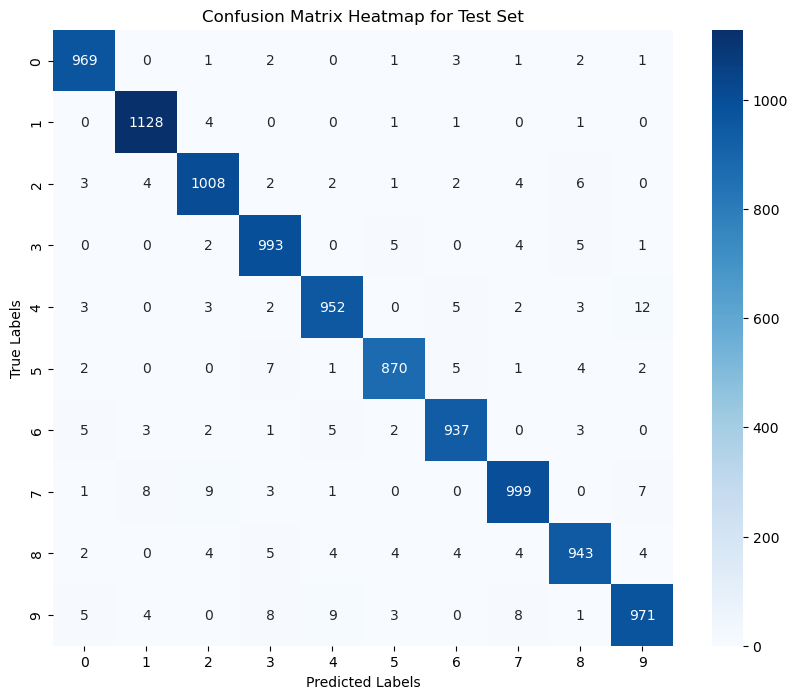

In [155]:
y_test_pred = np.argmax(MNIST_best_model1.loss(data['X_test']), axis=1)
conf_matrix = confusion_matrix(data['y_test'], y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix Heatmap for Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
